# Clusterización del universo de inversión de fondos

## Introducción y objetivo

Se entiende por el universo de inversión de fondos como aquel conjunto de fondos seleccionados y aprobados con el objetivo de construir sus propios fondos. Actualmente estos fondos se clasifican en base a criterios como que si el fondo es de Renta Fija (RF), Renta Variable (RV), Retorno Absoluto (RA) o Liquidez (LI), pasándose luego a subdividir esas categorías en otras basadas en el emisor (RF - Corporativa, RF - Emergentes, RF - Gobiernos) o la región (RV - EEUU, RV - Emergentes, RV - Global, RV - Japón) u otras.

Queremos aplicar clustering sobre el mismo universo de fondos con el objetivo de agrupar aquellos que tienen un comportamiento similar y poder aportar información adicional a una posible agrupación manual. Esto obliga a que los clusters formados deben ser explicables.

Queremos analizar los activos por su comportamiento en el largo plazo (5-10 años), para ello utilizaremos las siguientes características que describen a los fondos:
* Métricas relacionadas con los retornos de los fondos
    * **Momentum** a 10, 20, 25, 30, 40, 50, 60, 80, 90, 100 y 150 días.
    * Tomaremos **datos semanales** (miércoles) para eliminar el ruido de comienzo y fin de semana.
    * Tomaremos **datos mensuales** (último día de mes) para eliminar ruido de posibles movimientos bruscos a corto.
    * **Desviación estándar**: mide las fluctuaciones en rentabilidad (riesgo).
    * **Ratio de Sharpe**: rentabilidad que ofrece el fondo por cada unidad de riesgo que asume.
    * **Alpha**: mide la rentabilidad del fondo comparada con otro activo.
    * **Beta**: mide la volatilidad del fondo comparado con otro activo.
    * **Correlación** con otro activo.
    * **R2**: representa el porcentaje de variación de rentabilidad de la variable dependiente (en este caso la rentabilidad del fondo de inversión) que puede ser explicado por la variable independiente (la rentabilidad de otro activo).
    * **Tracking error**: mide la desviación de los resultados de un fondo respecto a su índice de referencia.
    * **Ratio de información**: mide la relación que existe entre el diferencial de rentabilidad de un fondo o cartera sobre su benchmark, y el riesgo que se asume en la gestión al separarse en mayor o menor medida del índice de referencia, también conocido como Tracking Error.
    * **Ratio de Treynor**: mide cuánto exceso de retorno se genera por cada unidad de riesgo.
    * **Max Drawdown**: mide la máxima caida del fondo en un periodo.
    * **Tiempo de recuperación medio**: mide el tiempo de recuperación medio de todos los drawdown con una duración superior a x periodos.
    * **Ratio de Calmar**: mide la rentabilidad de un fondo respecto a su drawdown.
    * **VaR**: mide la pérdida potencial con un determinado nivel de confianza.
    * **CVaR**: promedio ponderado de las pérdidas que exceden el VaR.
    * **EVaR**
    * **Skewness** y **Kurtosis**: asimetría y longitud de las colas en las distribuciones de los retornos respecto a la distribución normal.
* **Turnover Ratio**: la frecuencia de rotación de la cartera.
* **Total Expense Ratio** (TER): Ratio de los gastos totales de un fondo de inversión.
* **Tamaño del fondo**
* **Calidad del equipo gestor**
    * Difícil de cuantificar

## Proceso

1. En primer lugar haremos un preprocesado de los datos
    * Eliminación de características redundantes o correspondientes a períodos que no queremos.
    * Imputación de datos faltantes si procede.
    * Detección y eliminación de outliers si procede.

2. Sabemos que no todas las características aportarán información relevante, así que realizaremos un análisis de características para ver cuáles son las más importantes.

3. Clustering

    * Probaremos distintas técnicas de clustering
    * Estudiar número óptimo de clusters

4. Una vez tengamos formados los clusters
    * Realizar pruebas de importancia de características
        * Estudiar los clusters con GraphExt.
        * Entrenar modelo de clasificación utilizando las métricas como características para luego estudiar la importancia relativa de cada una de ellas.

In [1]:
import numpy as np
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns

## Lectura de datos

In [2]:
fondos_gestion = pd.read_excel("https://raw.githubusercontent.com/christianolivamoya/MIAX12-ML/main/data/Fondos%20Universo.xlsx", sheet_name="GestionData")
fondos_gestion.head(5)

,SUPERTIPO DE ACTIVO INFORME IT,TIPO DE ACTIVO INFORME IT,DESCRIPCION4,CODIGO_ISIN,CODIGO_BLOOMBERG,Suma de EFECTIVO,ID_ISIN,FUND_EURO_DIRECT_UCIT,FUND_CLASS_ASSETS,FUND_TOTAL_ASSETS,SFDR_CLASSIFICATION,FUND_EXPENSE_RATIO,CRNCY,FUND_TYP,FUND_OPEN_PYMNT_SHR,CURRENT_TRR_YTD,PREV_BUS_ANN_TRR_3YR,FUND_INCEPT_DT
0,LI,LI - Liquidez,PART. BNP INSTICASH EUR-I,LU0094219127,BNPICMI LX Equity,12797738.42,LU0094219127,Y,14250.33000,21779.347656,8,0.12,EUR,SICAV,Accumulation,3.223744,0.820604,29/03/2006
1,LI,LI - Liquidez,PART. GROUPAMA ENTERPRISES IC,FR0010213355,FINENTR FP Equity,8548510.35,FR0010213355,Y,3242.02300,5898.009000,8,0.08,EUR,FCP,Accumulation,3.303796,0.935299,09/03/1998
2,LI,LI - Liquidez,PART. AMUNDI -CASH EUR-I2 EUR C,LU0568620131,SOGMEBC LX Equity,8344543.83,LU0568620131,Y,232.27380,2913.607000,8,0.28,EUR,SICAV,Accumulation,3.065466,0.688696,18/06/2002
3,LI,LI - Liquidez,PART. GROUPAMA TRESORERIE RC EUR,FR0013296332,GRTRREU FP Equity,3808835.55,FR0013296332,Y,67.66330,6169.250000,8,0.04,EUR,FCP,Accumulation,3.243461,0.896470,02/12/2018
4,LI,LI - Liquidez,PART. AMUNDI CASH EUR-RD2 EUR C,LU0987193264,AMCSREC LX Equity,977595.84,LU0987193264,Y,93.06291,2913.607000,8,0.36,EUR,SICAV,Accumulation,2.987229,0.610282,04/03/2014


Datos de valores liquidativos en EUR

In [3]:
# Todos los NAV descargados en EUR para que incluyan efecto divisa
fondos_nav_refinitiv = pd.read_csv("https://raw.githubusercontent.com/christianolivamoya/MIAX12-ML/main/data/NAV-20131231-20231231.csv", index_col="Date", parse_dates=True)
fondos_nav_refinitiv.head(5)

,LU0094219127,FR0010213355,LU0568620131,FR0013296332,LU0987193264,LU0487547167,LU0839527339,LU0428380124,JE00BN2CJ301,IE00BYQDND46,...,LU1985812756,LU0329207053,LU1668657197,LU0828813369,LU0280430405,LU0256845834,IE00BFLQFY02,IE00BJQ2XG97,LU2367661365,IE00BKPFD774
Date,,,,,,,,,,,,,,,,,,,,,
2013-12-31,140.7963,2282.58,1015.08,NaN,99.6375,936.89,94.66,91.26,NaN,NaN,...,NaN,75.263410,NaN,8.752374,65.461369,127.090853,1.0362,NaN,NaN,NaN
2014-01-02,140.7981,2282.59,1015.11,NaN,99.6375,937.50,94.71,89.90,NaN,NaN,...,NaN,75.984990,NaN,8.763776,65.871086,127.027158,1.0362,NaN,NaN,NaN
2014-01-03,140.7986,2282.63,1015.11,NaN,99.6375,936.19,94.58,89.46,NaN,NaN,...,NaN,76.636810,NaN,8.777968,66.124911,127.717600,1.0362,NaN,NaN,NaN
2014-01-06,140.8001,2282.64,1015.14,NaN,99.6375,938.13,94.77,89.01,NaN,NaN,...,NaN,76.060829,NaN,8.708211,65.751392,127.060716,1.0469,NaN,NaN,NaN
2014-01-07,140.8006,2282.65,1015.14,NaN,99.6375,933.45,94.30,89.87,NaN,NaN,...,NaN,75.584244,NaN,8.790043,66.432438,128.411058,1.0406,NaN,NaN,NaN


Datos cuantitativos de los fondos

In [4]:
fondos_quant_refinitiv = pd.read_csv("https://raw.githubusercontent.com/christianolivamoya/MIAX12-ML/main/data/FondosQuantitative.csv", index_col=0)
fondos_quant_refinitiv.head(5)

,Instrument,Performance_for_1_Year_to_Last_Month_End,Performance_for_3_Year_to_Last_Month_End,Alpha_for_1_Year_to_Last_Month_End,Alpha_for_3_Years_to_Last_Month_End,Alpha_for_5_Years_to_Last_Month_End,Alpha_for_10_Years_to_Last_Month_End,Beta_for_1_Year_to_Last_Month_End,Beta_for_3_Years_to_Last_Month_End,Beta_for_5_Years_to_Last_Month_End,...,Treynor_Ratio_for_10_Years_to_Last_Month_End,Correlation_for_1_Year_to_Last_Month_End,Correlation_for_3_Years_to_Last_Month_End,Correlation_for_5_Years_to_Last_Month_End,Correlation_for_10_Years_to_Last_Month_End,Tracking_Error_for_1_Year_to_Last_Month_End,Tracking_Error_for_3_Years_to_Last_Month_End,Tracking_Error_for_5_Years_to_Last_Month_End,Tracking_Error_for_10_Years_to_Last_Month_End,Daily_Value_Traded
0,LU0094219127,3.521022,3.030274,0.007582,0.002053,0.002456,0.001094,1.020756,1.074998,1.082828,...,-0.008113,0.651589,0.885311,0.897681,0.886533,0.013783,0.009876,0.007917,0.006124,0.0
1,FR0010213355,3.628189,3.387763,0.022508,0.012127,0.015119,0.014346,1.463659,1.101239,1.190834,...,0.003242,0.570665,0.783271,0.764838,0.742657,0.024983,0.015254,0.015024,0.011735,0.0
2,LU0568620131,3.387006,2.635353,0.000625,-0.009676,-0.005001,0.001805,1.290547,1.013591,1.130268,...,-0.007743,0.758674,0.859137,0.848565,0.805855,0.013286,0.010471,0.010547,0.010911,0.0
3,FR0013296332,3.559981,3.274767,0.027242,0.011840,0.017535,NaN,2.181703,1.260457,1.411420,...,NaN,0.673553,0.715690,0.650814,NaN,0.030929,0.021797,0.024974,NaN,0.0
4,LU0987193264,3.301790,2.385564,-0.007542,-0.016572,-0.011320,0.003268,1.199469,1.006233,1.128861,...,-0.006894,0.765783,0.852206,0.833266,0.400174,0.011908,0.010712,0.011185,0.037162,0.0


Otros datos de los fondos

In [5]:
fondos_overview_refinitiv = pd.read_csv("https://raw.githubusercontent.com/christianolivamoya/MIAX12-ML/main/data/FondosOverview.csv", index_col=0)
fondos_overview_refinitiv.head(5)

,Instrument,Main Index,Main Index RIC,First Trade Date,Fund Type,Geographic Focus,Currency,Total Expense Ratio,Benchmark Type,Benchmark Name,Benchmark Instrument Code,Benchmark Instrument RIC
0,LU0094219127,NaN,NaN,NaN,Money Market,EuroZone,EUR,0.10,Fund Manager,Euro Short Term Rate EUR,11063860.0,EUROSTR=
1,FR0010213355,NaN,NaN,NaN,Money Market,EuroZone,EUR,0.10,Fund Manager,Index is not available on Lipper Database,11000000.0,NaN
2,LU0568620131,NaN,NaN,NaN,Money Market,EuroZone,EUR,0.28,Fund Manager,EURIBOR 3 Month,11000131.0,EURIBOR3MD=X
3,FR0013296332,NaN,NaN,NaN,Money Market,EuroZone,EUR,0.07,Fund Manager,Index is not available on Lipper Database,11000000.0,NaN
4,LU0987193264,NaN,NaN,NaN,Money Market,EuroZone,EUR,0.36,Fund Manager,EURIBOR 3 Month,11000131.0,EURIBOR3MD=X


Añadimos TER a "fondos_quant_refinitiv"

In [6]:
fondos_quant_refinitiv.set_index("Instrument", inplace=True)
fondos_overview_refinitiv.set_index("Instrument", inplace=True)
fondos_quant_refinitiv["TER"] = fondos_overview_refinitiv["Total Expense Ratio"]

In [7]:
fondos_quant_refinitiv.describe()

,Performance_for_1_Year_to_Last_Month_End,Performance_for_3_Year_to_Last_Month_End,Alpha_for_1_Year_to_Last_Month_End,Alpha_for_3_Years_to_Last_Month_End,Alpha_for_5_Years_to_Last_Month_End,Alpha_for_10_Years_to_Last_Month_End,Beta_for_1_Year_to_Last_Month_End,Beta_for_3_Years_to_Last_Month_End,Beta_for_5_Years_to_Last_Month_End,Beta_for_10_Years_to_Last_Month_End,...,Correlation_for_1_Year_to_Last_Month_End,Correlation_for_3_Years_to_Last_Month_End,Correlation_for_5_Years_to_Last_Month_End,Correlation_for_10_Years_to_Last_Month_End,Tracking_Error_for_1_Year_to_Last_Month_End,Tracking_Error_for_3_Years_to_Last_Month_End,Tracking_Error_for_5_Years_to_Last_Month_End,Tracking_Error_for_10_Years_to_Last_Month_End,Daily_Value_Traded,TER
count,135.000000,133.000000,135.000000,133.000000,118.000000,68.000000,132.000000,130.000000,114.000000,67.000000,...,132.000000,130.000000,114.000000,67.000000,135.000000,133.000000,118.000000,68.000000,1.360000e+02,136.000000
mean,7.441668,6.705789,-0.022435,-0.166478,0.004018,0.040326,0.864886,0.806840,0.871770,0.851815,...,0.704117,0.735840,0.772330,0.774734,1.647505,1.920250,1.905478,1.577265,3.913871e+06,0.719620
std,12.575919,21.402817,0.826729,0.550946,0.267798,0.190493,0.587879,0.369829,0.377343,0.345709,...,0.376195,0.303496,0.281555,0.274377,1.255836,1.434922,1.454808,1.179697,4.071580e+07,0.442997
min,-32.202532,-58.273606,-2.088958,-2.525913,-0.973757,-0.467946,-1.735145,-0.139254,-0.226974,-0.091234,...,-0.569720,-0.185293,-0.279158,-0.115216,0.006313,0.005725,0.007917,0.006124,0.000000e+00,0.070000
25%,3.238607,-6.733106,-0.256631,-0.315162,-0.095666,-0.073197,0.622276,0.673271,0.735839,0.624673,...,0.608240,0.680891,0.746756,0.756995,0.480261,0.670975,0.547929,0.364910,0.000000e+00,0.357500
50%,5.305503,3.254970,0.022508,-0.040716,0.015502,0.003306,0.982824,0.927243,0.978707,0.961968,...,0.880772,0.850558,0.872468,0.881530,1.486493,1.817290,1.846649,1.569953,0.000000e+00,0.700000
75%,12.031202,19.746360,0.149983,0.045155,0.095585,0.123774,1.142139,1.024995,1.063348,1.040086,...,0.945613,0.947210,0.963759,0.969278,2.484332,2.799774,2.873038,2.425833,0.000000e+00,1.006500
max,45.183845,74.534334,3.733767,1.338487,0.702199,0.616904,2.871705,1.735121,2.263916,1.446194,...,0.999999,0.999999,0.999976,0.999961,6.515011,7.617264,6.874441,4.897103,4.745022e+08,2.310000


Datos de índices

In [8]:
data_idx = pd.read_csv(
    "https://raw.githubusercontent.com/christianolivamoya/MIAX12-ML/main/data/Close-IDX-20131231-20231231.csv", index_col=0, parse_dates=True
)
data_idx.sort_index(inplace=True)
data_idx.head(5)

,.CSI716567,.dMICN00000NUS,.dMIEF00000NUS,.dMIEF00000PUS,.dMIEM00000PEU,.dMIEU00000GEU,.dMIEU00000NEU,.dMIEU0000VGUS,.dMIEU2D000PEU,.dMIIN00000NUS,...,.TOPXDVNET,.WTDGITR,.XNDX,.XNDXNNRL,SYBA.DE,SYBU.DE,.TFRURANLLU,EURIBOR1M,EURIBOR3M,PWHEAMTUSDM
2013-12-31,NaN,390.268,410.500991,1002.692770,102.320,178.099,165.542,11210.35,NaN,436.520,...,NaN,NaN,3881.55,3439.77,NaN,NaN,NaN,0.2144,0.2735,NaN
2014-01-01,NaN,390.268,410.488232,1002.661604,102.320,178.099,165.542,11210.35,NaN,436.306,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,229.980359
2014-01-02,NaN,389.552,405.661384,990.788119,101.012,176.681,164.223,11012.07,NaN,428.969,...,NaN,NaN,3851.70,3386.30,54.85,75.69,NaN,NaN,NaN,NaN
2014-01-03,NaN,380.809,401.042303,979.487022,101.540,177.637,165.112,11023.90,NaN,429.777,...,NaN,NaN,3824.86,3339.05,54.91,75.96,NaN,NaN,NaN,NaN
2014-01-06,NaN,376.426,398.163032,972.419974,101.439,177.240,164.743,11025.44,NaN,427.916,...,1671.12,NaN,3812.14,3316.68,54.97,75.90,NaN,NaN,NaN,NaN


In [9]:
supertipos_activos = fondos_gestion.loc[:, "SUPERTIPO DE ACTIVO INFORME IT"].unique()
print(supertipos_activos)
print(len(supertipos_activos))

['LI' 'RA' 'RF' 'RV']
4


In [10]:
tipos_activos = fondos_gestion.loc[:, "TIPO DE ACTIVO INFORME IT"].unique()
print(tipos_activos)
print(len(tipos_activos))

['LI - Liquidez' 'RA - Multiactivo' 'RF - Convertibles' 'RF - Corporativa'
 'RF - Emergentes' 'RF - Gobiernos' 'RV - EEUU' 'RV - Emergentes'
 'RV - Global' 'RV - Japón' 'RA - Renta Variable']
11


## Filtrado de los datos a usar

El primer paso es filtrar aquellas características irrelevantes o redundantes. Para ello, lo que más parece lógico es eliminar aquellas con una alta correlación en valor absoluto.

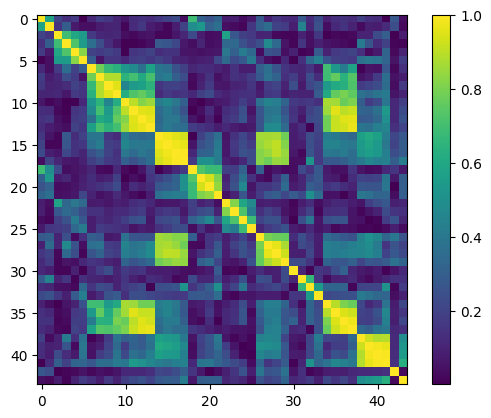

In [11]:
plt.imshow(fondos_quant_refinitiv.corr().abs())
plt.colorbar()
plt.show()

In [12]:
umbral = 0.6
filas = np.where(fondos_quant_refinitiv.corr().abs() > umbral)[0]
columnas = np.where(fondos_quant_refinitiv.corr().abs() > umbral)[1]

eliminar = []
for f, c in zip(filas, columnas):
  if f == c:
    continue
  eliminar.append(np.max([f, c]))
eliminar = list(set(eliminar))
fondos_quant_refinitiv.columns[eliminar]

Index(['Alpha_for_3_Years_to_Last_Month_End',
       'Alpha_for_5_Years_to_Last_Month_End',
       'Alpha_for_10_Years_to_Last_Month_End',
       'Beta_for_3_Years_to_Last_Month_End',
       'Beta_for_5_Years_to_Last_Month_End',
       'Beta_for_10_Years_to_Last_Month_End',
       'R_Squared_for_1_Year_to_Last_Month_End',
       'R_Squared_for_3_Years_to_Last_Month_End',
       'R_Squared_for_5_Years_to_Last_Month_End',
       'R_Squared_for_10_Years_to_Last_Month_End',
       'Standard_Deviation_for_3_Years_to_Last_Month_End',
       'Standard_Deviation_for_5_Years_to_Last_Month_End',
       'Standard_Deviation_for_10_Years_to_Last_Month_End',
       'Sharpe_Ratio_for_1_Year_to_Last_Month_End',
       'Sharpe_Ratio_for_3_Years_to_Last_Month_End',
       'Sharpe_Ratio_for_5_Years_to_Last_Month_End',
       'Sharpe_Ratio_for_10_Years_to_Last_Month_End',
       'Information_Ratio_for_3_Years_to_Last_Month_End',
       'Information_Ratio_for_5_Years_to_Last_Month_End',
       'Information

In [13]:
fondos_quant_refinitiv = fondos_quant_refinitiv.drop(columns=fondos_quant_refinitiv.columns[list(eliminar)], axis=1)
fondos_quant_refinitiv.head()

,Performance_for_1_Year_to_Last_Month_End,Performance_for_3_Year_to_Last_Month_End,Alpha_for_1_Year_to_Last_Month_End,Beta_for_1_Year_to_Last_Month_End,Standard_Deviation_for_1_Year_to_Last_Month_End,Information_Ratio_for_1_Year_to_Last_Month_End,Treynor_Ratio_for_1_Year_to_Last_Month_End,Treynor_Ratio_for_3_Years_to_Last_Month_End,Treynor_Ratio_for_10_Years_to_Last_Month_End,Tracking_Error_for_1_Year_to_Last_Month_End,Daily_Value_Traded
Instrument,,,,,,,,,,,
LU0094219127,3.521022,3.030274,0.007582,1.020756,0.189819,0.528654,-0.006799,-0.015362,-0.008113,0.013783,0.0
FR0010213355,3.628189,3.387763,0.022508,1.463659,0.214063,0.636788,0.001145,-0.006260,0.003242,0.024983,0.0
LU0568620131,3.387006,2.635353,0.000625,1.290547,0.191707,-0.264099,-0.013743,-0.026817,-0.007743,0.013286,0.0
FR0013296332,3.559981,3.274767,0.027242,2.181703,0.239145,0.336969,-0.001747,-0.007880,NaN,0.030929,0.0
LU0987193264,3.301790,2.385564,-0.007542,1.199469,0.188003,-0.871690,-0.020515,-0.033740,-0.006894,0.011908,0.0


## Limpieza de datos

In [14]:
fondos_nav_refinitiv.shape

(2603, 141)

In [15]:
# Tomamos los datos de valor liquidativo semanales en los miércoles
fondos_nav_refinitiv = fondos_nav_refinitiv.resample("W-Wed").last()

In [16]:
# Nos quedamos con los 3 últimos años de datos semanales
num_semanas_por_año = 52
num_años = 3
fondos_nav_refinitiv = fondos_nav_refinitiv.iloc[-num_semanas_por_año * num_años:]
fondos_nav_refinitiv = fondos_nav_refinitiv.dropna(axis=1, how="any")

<Axes: >

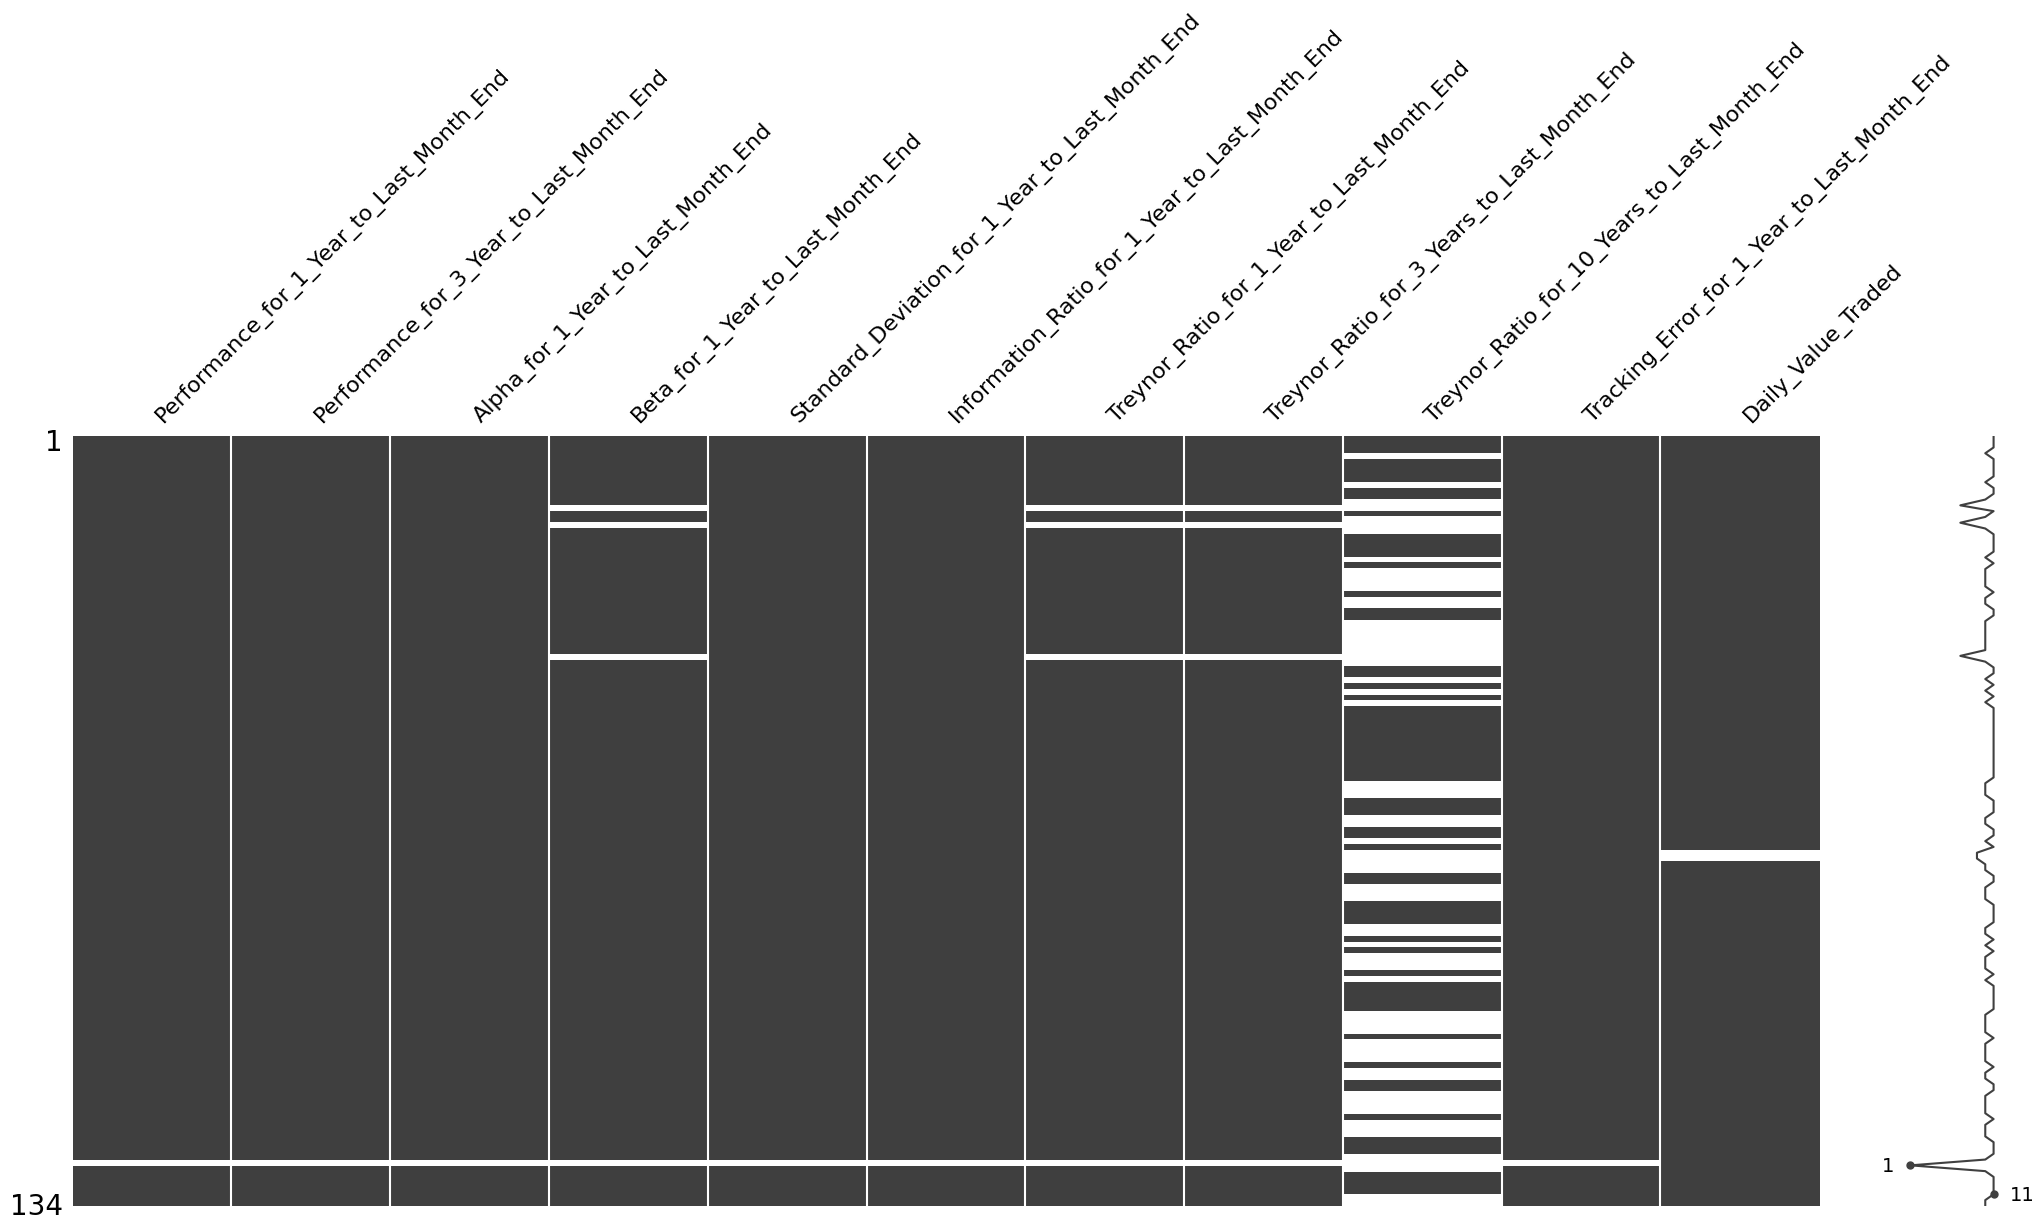

In [17]:
# De los fondos para los cuales tenemos datos de NAV, visualizamos las características cuantitativas de las que disponemos
msno.matrix(fondos_quant_refinitiv.loc[fondos_nav_refinitiv.columns, :])

<Axes: >

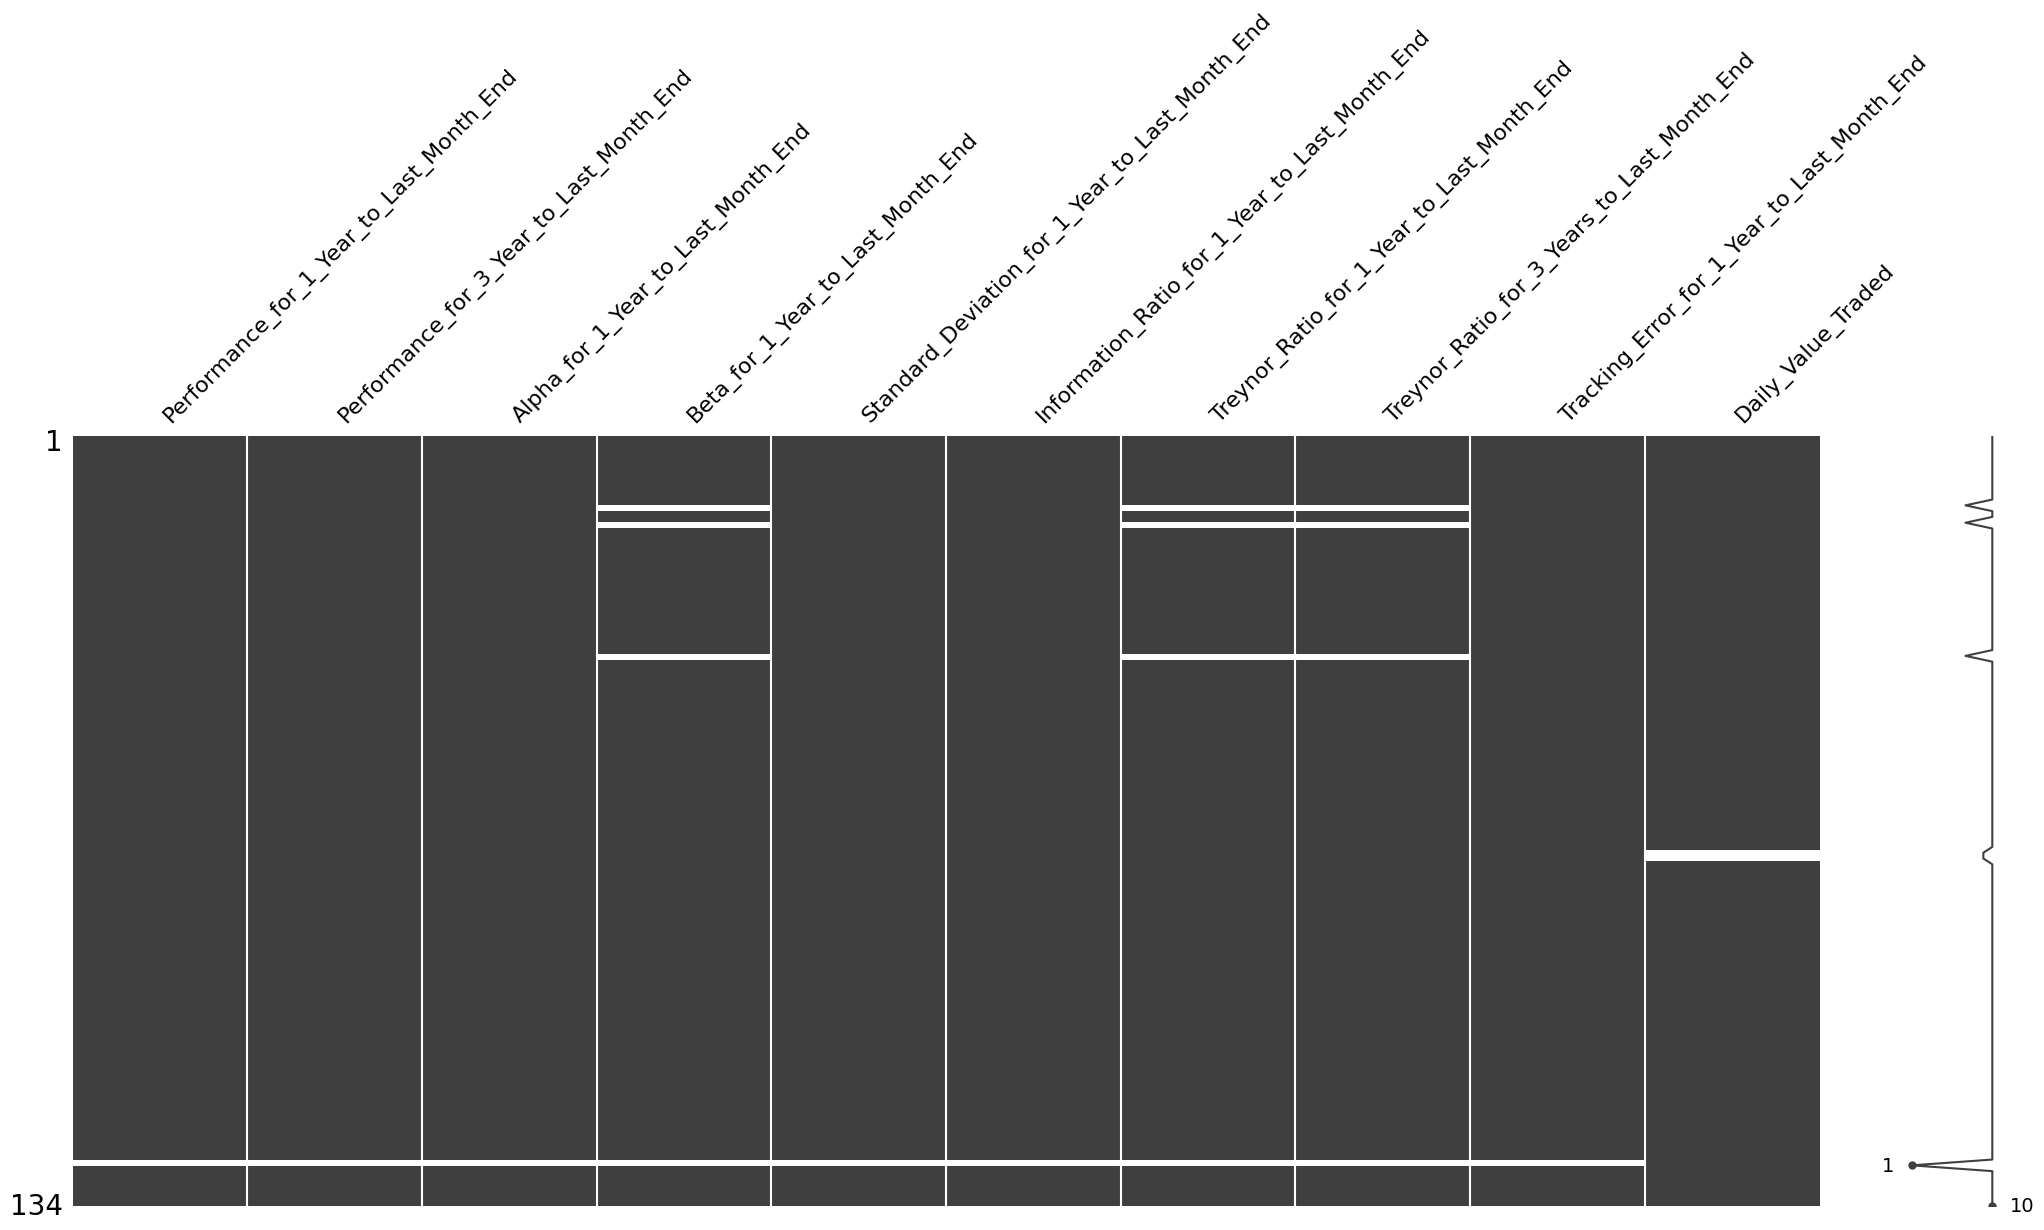

In [18]:
fondos_quant_refinitiv = fondos_quant_refinitiv.drop(columns=["Treynor_Ratio_for_10_Years_to_Last_Month_End"])

# De los fondos para los cuales tenemos datos de NAV, visualizamos las características cuantitativas de las que disponemos
msno.matrix(fondos_quant_refinitiv.loc[fondos_nav_refinitiv.columns, :])

<Axes: >

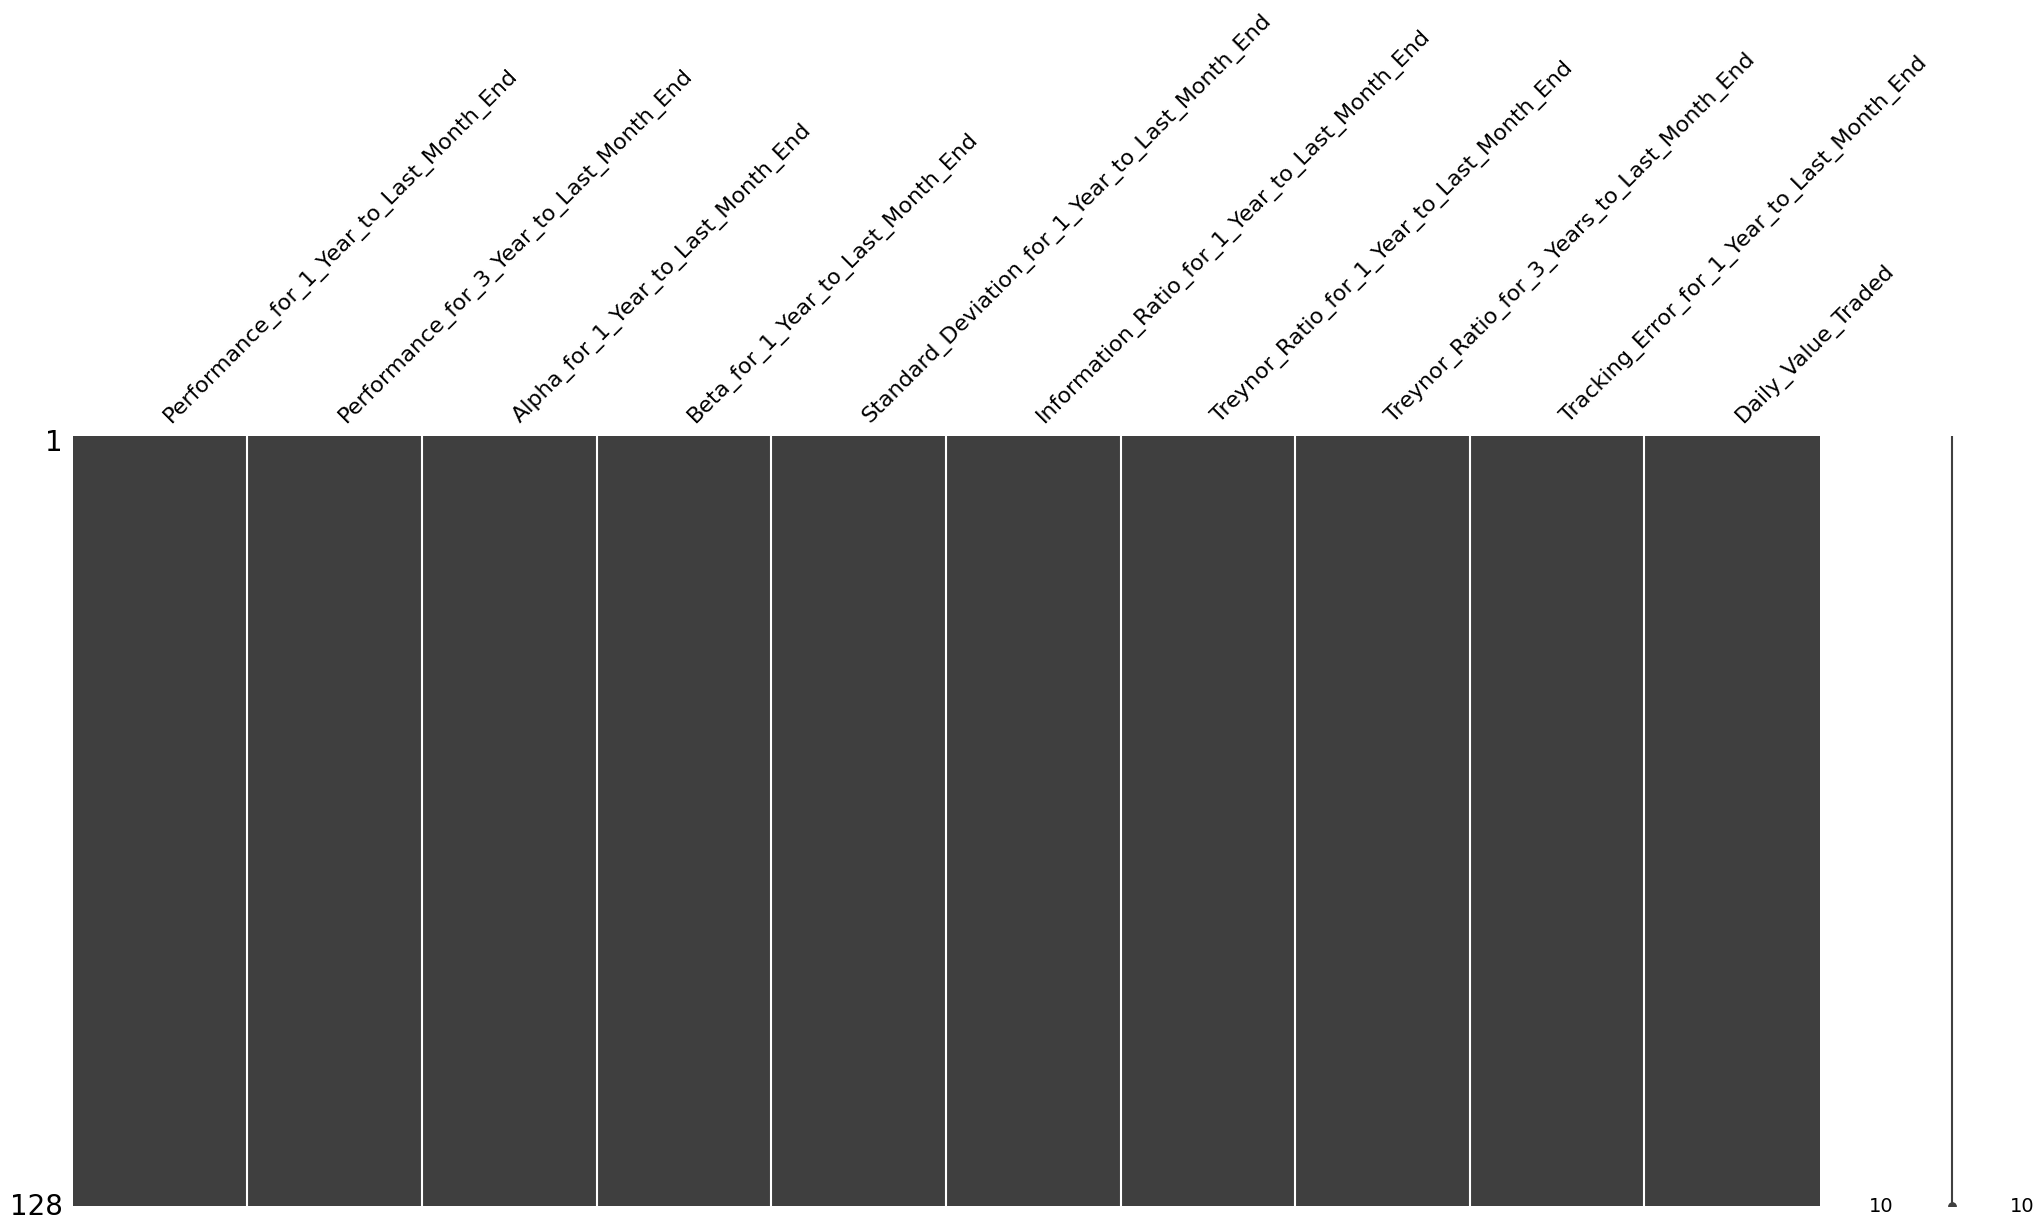

In [19]:
# Eliminamos todos los fondos de los que no tenemos todos los datos cuantitativos
fondos_quant_refinitiv = fondos_quant_refinitiv.dropna(axis=0, how="any")

msno.matrix(fondos_quant_refinitiv)

In [20]:
fondos_quant_refinitiv.describe()

,Performance_for_1_Year_to_Last_Month_End,Performance_for_3_Year_to_Last_Month_End,Alpha_for_1_Year_to_Last_Month_End,Beta_for_1_Year_to_Last_Month_End,Standard_Deviation_for_1_Year_to_Last_Month_End,Information_Ratio_for_1_Year_to_Last_Month_End,Treynor_Ratio_for_1_Year_to_Last_Month_End,Treynor_Ratio_for_3_Years_to_Last_Month_End,Tracking_Error_for_1_Year_to_Last_Month_End,Daily_Value_Traded
count,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,1.280000e+02
mean,7.869508,7.216978,-0.020384,0.873355,10.283776,-0.012285,0.852460,0.103434,1.660414,4.151685e+06
std,12.493293,21.190089,0.841810,0.589108,7.047767,0.542810,7.034882,1.498517,1.255011,4.196703e+07
min,-32.202532,-58.273606,-2.088958,-1.735145,0.188003,-3.887974,-3.686486,-9.917872,0.006313,0.000000e+00
25%,3.365702,-5.461583,-0.264369,0.642481,4.211546,-0.196753,-0.235527,-0.386427,0.544206,0.000000e+00
50%,5.309959,3.264868,0.016298,0.983963,10.327437,-0.008860,0.166437,0.017521,1.496517,0.000000e+00
75%,12.403150,20.196506,0.138502,1.145677,15.153787,0.183260,0.830736,0.587939,2.478036,0.000000e+00
max,45.183845,74.534334,3.733767,2.871705,29.575072,1.495589,78.579568,8.912112,6.515011,4.745022e+08


In [21]:
print(f"Dataset final con {fondos_quant_refinitiv.shape[0]} fondos y {fondos_quant_refinitiv.shape[1]} características")

Dataset final con 128 fondos y 10 características


### Normalización

Normalizar las características es necesario antes de aplicar cualquier técnica de clustering.

In [22]:
# Normalizamos los datos para que todas las características tengan media cero y desviación estándar uno
means = fondos_quant_refinitiv.mean()
stds = fondos_quant_refinitiv.std()
fondos_quant_refinitiv_norm = (fondos_quant_refinitiv - means) / stds

In [23]:
fondos_quant_refinitiv_norm.describe()

,Performance_for_1_Year_to_Last_Month_End,Performance_for_3_Year_to_Last_Month_End,Alpha_for_1_Year_to_Last_Month_End,Beta_for_1_Year_to_Last_Month_End,Standard_Deviation_for_1_Year_to_Last_Month_End,Information_Ratio_for_1_Year_to_Last_Month_End,Treynor_Ratio_for_1_Year_to_Last_Month_End,Treynor_Ratio_for_3_Years_to_Last_Month_End,Tracking_Error_for_1_Year_to_Last_Month_End,Daily_Value_Traded
count,1.280000e+02,1.280000e+02,1.280000e+02,1.280000e+02,1.280000e+02,1.280000e+02,1.280000e+02,1.280000e+02,1.280000e+02,128.000000
mean,-8.326673e-17,2.775558e-17,-2.428613e-17,3.816392e-17,-1.179612e-16,-1.387779e-17,6.938894e-18,-3.469447e-18,-2.775558e-17,0.000000
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000
min,-3.207484e+00,-3.090623e+00,-2.457292e+00,-4.427879e+00,-1.432478e+00,-7.140048e+00,-6.452057e-01,-6.687484e+00,-1.317998e+00,-0.098927
25%,-3.604980e-01,-5.983250e-01,-2.898337e-01,-3.919047e-01,-8.615821e-01,-3.398385e-01,-1.546561e-01,-3.268977e-01,-8.894015e-01,-0.098927
50%,-2.048739e-01,-1.865075e-01,4.357514e-02,1.877554e-01,6.195056e-03,6.309844e-03,-9.751732e-02,-5.733247e-02,-1.305941e-01,-0.098927
75%,3.628860e-01,6.125282e-01,1.887441e-01,4.622613e-01,6.910006e-01,3.602462e-01,-3.088105e-03,3.233225e-01,6.514855e-01,-0.098927
max,2.986750e+00,3.176832e+00,4.459616e+00,3.392162e+00,2.737221e+00,2.777905e+00,1.104881e+01,5.878264e+00,3.868170e+00,11.207622


# Ejercicio

A partir de los datos generados, utiliza algún algoritmo de clustering, el que más creas conveniente, para agrupar los fondos resultantes. Luego, visualiza el resultado utilizando alguna proyección a 2D e implementa un árbol de decisión que explique la clusterización.

# GraphExt

Asignacion de clusters a fondos

In [ ]:
data_analysis = fondos_quant_refinitiv.copy()
data_analysis["custom_cluster"] = cluster_labels

Asignación de etiquetas de clasificación de gestores

In [ ]:
funds = fondos_quant_refinitiv_norm.index.values
mask = fondos_gestion["CODIGO_ISIN"].isin(funds)
data_analysis["SUPERTIPO"] = fondos_gestion.loc[mask, "SUPERTIPO DE ACTIVO INFORME IT"].values
data_analysis["TIPO"] = fondos_gestion.loc[mask, "TIPO DE ACTIVO INFORME IT"].values

In [ ]:
data_analysis.to_csv("datos_graphext.csv")